# Customer Churn Prediction Using Logistic Regression

## Load libraries and the dataset

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)
from imblearn.over_sampling import SMOTE

In [3]:
# Load dataset
df = pd.read_csv('Telco-Customer-Churn.csv')

In [4]:
# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Streami

In [5]:
# Display basic info
print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  70

In [6]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


##  Exploratory Data Analysis (EDA)

In [7]:
# Check target variable distribution
print("\nTarget Variable Distribution:")
print(df['Churn'].value_counts())


Target Variable Distribution:
No     5174
Yes    1869
Name: Churn, dtype: int64


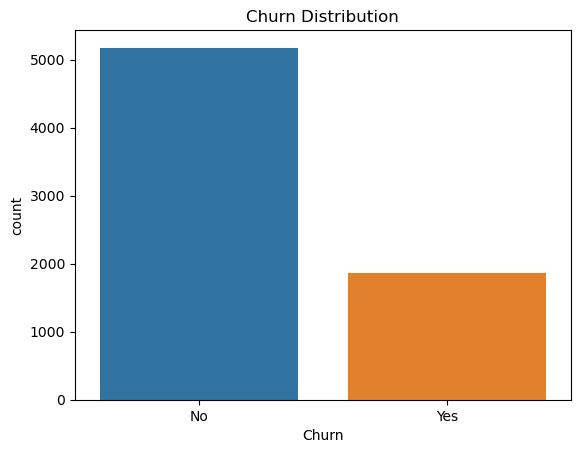

In [8]:
# Plot churn distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

In [9]:
# Analyze numerical features
print("\nStatistical Summary of Numerical Features:")
print(df.describe())


Statistical Summary of Numerical Features:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


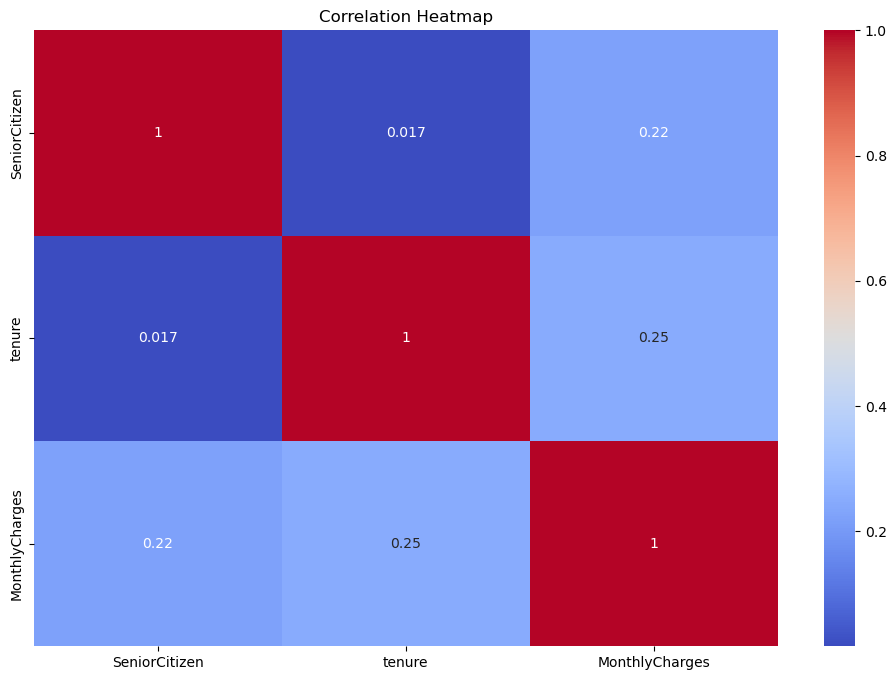

In [10]:
# Correlation heatmap (numerical features only)
plt.figure(figsize=(12, 8))
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

##  Data Preprocessing

In [11]:
# Encode categorical features
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if col != 'Churn':  # Exclude target variable
        df[col] = le.fit_transform(df[col])

In [12]:
# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [13]:
# Verify preprocessing
print("\nData after preprocessing:")
print(df.head())


Data after preprocessing:
   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0        5375       0              0        1           0       1   
1        3962       1              0        0           0      34   
2        2564       1              0        0           0       2   
3        5535       1              0        0           0      45   
4        6511       0              0        0           0       2   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0             0              1                0               0  ...   
1             1              0                0               2  ...   
2             1              0                0               2  ...   
3             0              1                0               2  ...   
4             1              0                1               0  ...   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0    

## Feature Engineering

In [14]:
# Define features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [15]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [16]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [17]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Model Building and Training

In [18]:
# Initialize Logistic Regression model
logreg = LogisticRegression()

In [19]:
# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='roc_auc')

In [20]:
# Best model
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


## Model Evaluation

In [21]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [22]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display metrics
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Model Evaluation Metrics:
Accuracy: 0.8266
Precision: 0.8032
Recall: 0.8713
F1-Score: 0.8358
ROC-AUC: 0.9016


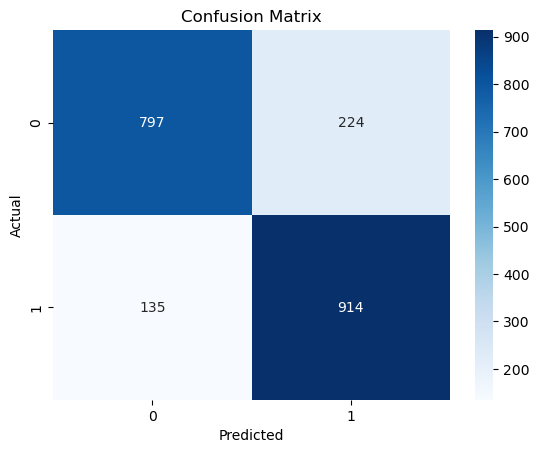

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

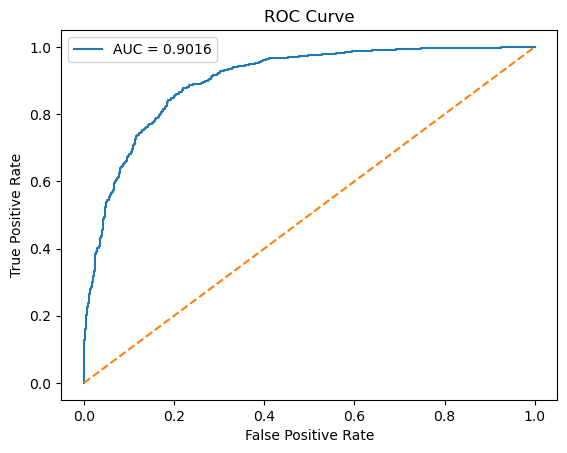

In [27]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()